In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.visualization import ZScaleInterval
get_ipython().run_line_magic('matplotlib', 'inline')
from astropy.io import fits 
import astropy.modeling as modeling
from astropy.modeling import models, fitting
from scipy.optimize import minimize
from astropy.stats import sigma_clip
from photutils.psf import extract_stars
from astropy.nddata import NDData
from astropy.table import Table
from photutils.psf import EPSFBuilder
from astropy.visualization import simple_norm
import multiprocess as mp
from functools import partial
import inspect
plt.rcParams.update({"figure.facecolor":  (1.0, 1.0, 1.0, 1.0)})
import warnings
warnings.filterwarnings('ignore')

In [3]:
spots = fits.getdata('S20131212S0024_H-polcal.fits')

spot_xcents = []
spot_ycents = []
spot_rotangles = []
spot_xwidths = []
spot_ywidths = []
for i, pol in enumerate(spots):
    for j, first in enumerate(pol):
        for k, second in enumerate(first):
            if not np.isnan(second[0]):
                spot_xcents.append(second[0])
                spot_ycents.append(second[1])
                spot_rotangles.append(-second[2])
                spot_xwidths.append(second[3])
                spot_ywidths.append(second[4])
print('Lengths: '+str(len(spot_xcents)))
print()
print('Ranges:')
print('xcents: '+str(np.nanmin(spot_xcents))+' - '+str(np.nanmax(spot_xcents)))
print('ycents: '+str(np.nanmin(spot_ycents))+' - '+str(np.nanmax(spot_ycents)))
print('rotangles: '+str(np.nanmin(spot_rotangles))+' - '+str(np.nanmax(spot_rotangles)))
print('xwidths: '+str(np.nanmin(spot_xwidths))+' - '+str(np.nanmax(spot_xwidths)))
print('ywidths: '+str(np.nanmin(spot_ywidths))+' - '+str(np.nanmax(spot_ywidths)))

flat = fits.getdata('S20131212S0022.fits')


Lengths: 72030

Ranges:
xcents: 5.62977 - 2042.0929
ycents: 6.4392724 - 2042.1277
rotangles: -179.99829 - -0.0
xwidths: 0.48483393 - 5.6349506
ywidths: 0.19469325 - 5.0699363


In [4]:
# Function returning the summed squared residuals between two ndarrays, where one is an evaluated ePSF model
def epsf_residuals(guesses, x,y,data,model):
    
    """
    Generates an ePSF model based on guessed parameters and returns the sum of the squared residuals
    between that model and an image of a GPI spot. For use in conjunction with the scipy.optimize.minimize() function.
    
    Parameters:
    
        guesses (iterable): set of model parameters being tested.
        
            guesses[0]: estimate of the flux in the data image (sum of the pixel values without background).
            guesses[1]: estimate of the spot's x center.
            guesses[2]: estimate of the spot's y center.
            guesses[3]: estimate of the background level.
        
        x,y (numpy.ndarray objects): meshgrids the model uses to generate an artificial image of the spot.
        
        data (numpy.ndarray object): image of the spot being replicated.
        
        model (EPSFModel object): ePSF model that is replicating the GPI spot.
        
        
    Returns:
    
        sum_squared_residuals (float): the sum of the squared residuals when the model image is subtracted from the original image.
        
    """
    
    difference = data - (model.evaluate(x=x,y=y,flux=guesses[0], x_0=guesses[1], y_0=guesses[2])+guesses[3])
    return np.sum(difference**2)

In [5]:
#Function for generating artificial ePSF image
def model_gen_sub(argument):
    
    #Bounds for the box in which a single model is recycled
    same_model_bounds = argument[0]
    #Bounds for the box from which the sample spots are drawn
    model_input_bounds = argument[1]
    #Half-width of the box drawn around each ePSF
    box_half_width = argument[2]
    
    #find the spots in the same model region and the input region
    same_model_mask = np.zeros(len(spot_ycents),dtype=bool)
    for i, y in enumerate(spot_ycents):
        if (spot_ycents[i] >= same_model_bounds[0] and spot_ycents[i] <= same_model_bounds[1]
            and spot_xcents[i] >= same_model_bounds[2] and spot_xcents[i] <= same_model_bounds[3]):
            same_model_mask[i]=True
        
    same_model_ycents = np.array(spot_ycents)[same_model_mask]
    same_model_xcents = np.array(spot_xcents)[same_model_mask]
        
    model_input_mask = np.zeros(len(spot_ycents),dtype=bool)
    for i, y in enumerate(spot_ycents):
        if (spot_ycents[i] >= model_input_bounds[0] and spot_ycents[i] <= model_input_bounds[1]
            and spot_xcents[i] >= model_input_bounds[2] and spot_xcents[i] <= model_input_bounds[3]):
            model_input_mask[i]=True
        
    input_ycents = np.array(spot_ycents)[model_input_mask]
    input_xcents = np.array(spot_xcents)[model_input_mask]
    
    #Identify the central spot and mask it from the arrays
    centery = (same_model_bounds[0]+same_model_bounds[1])/2; centerx = (same_model_bounds[2]+same_model_bounds[3])/2
    input_cent_offs = ( (input_ycents-centery)**2 + (input_xcents-centerx)**2 )**0.5
    cent_ind = np.argmin(input_cent_offs)
    nocentmask = np.ones(len(input_ycents),dtype=bool)
    nocentmask[cent_ind]=False
    input_ycents = input_ycents[nocentmask]
    input_xcents = input_xcents[nocentmask]
    
    #Copy the section of the original image
    current_section = flat[model_input_bounds[0]:model_input_bounds[1],
                           model_input_bounds[2]:model_input_bounds[3]] -np.nanmedian(flat[model_input_bounds[0]:model_input_bounds[1],
                                                                                           model_input_bounds[2]:model_input_bounds[3]])
    
    #Generate the EPSFBuilder
    nddata=NDData(data=current_section)
    input_tbl = Table()
    input_tbl['x'] = input_xcents - model_input_bounds[2]
    input_tbl['y'] = input_ycents - model_input_bounds[0]
    input_spots = extract_stars(nddata, input_tbl, size=2*box_half_width+1)
    
    print('')
    #print(input_tbl)
    print('# spots: '+str(len(input_xcents))+'; extracted: '+str(len(input_spots)))

    epsf_builder = EPSFBuilder(oversampling=4, maxiters=1)  
    epsf, fitted_stars = epsf_builder(input_spots)
    
    for i, spot in enumerate(same_model_ycents):
        #Darw a box around the current PSF
        current_ycent = same_model_ycents[i]; current_xcent = same_model_xcents[i]
        round_ycent = int(round(current_ycent,0)); round_xcent = int(round(current_xcent,0))

        box_bounds = []
        
        if round_ycent-box_half_width >= 0:
            box_bounds.append(round_ycent-box_half_width)
        else:
            box_bounds.append(0)

        if round_ycent+box_half_width <= len(flat):
            box_bounds.append(round_ycent+box_half_width)
        else:
            box_bounds.append(len(flat))

        if round_xcent-box_half_width >= 0:
            box_bounds.append(round_xcent-box_half_width)
        else:
            box_bounds.append(0)

        if round_xcent+box_half_width <= len(flat):
            box_bounds.append(round_xcent+box_half_width)
        else:
            box_bounds.append(len(flat))
            
        x,y = np.mgrid[:box_bounds[1]-box_bounds[0],:box_bounds[3]-box_bounds[2]]

        center_spot = flat[box_bounds[0]:box_bounds[1], box_bounds[2]:box_bounds[3]]

        #Get the best-fit parameters for the ePSF
        
        spot_results = minimize(epsf_residuals, [np.sum(center_spot), current_ycent-box_bounds[0],
                                                 current_xcent-box_bounds[2],
                                                 np.nanmedian(flat[model_input_bounds[0]:model_input_bounds[1],
                                                                   model_input_bounds[2]:model_input_bounds[3]])],
                                args=(y, x, center_spot, epsf)).x
        
        
        #Evaluate the ePSF
        eval_model = epsf.evaluate(x=y,y=x,flux=spot_results[0],
                                   x_0=spot_results[1], y_0=spot_results[2]) + spot_results[3]
        
        #Put it into the artificial image
        artificial_extracted_image[box_bounds[0]:box_bounds[1], box_bounds[2]:box_bounds[3]]=eval_model
    
    return [artificial_extracted_image, epsf]


# spots: 174; extracted: 155


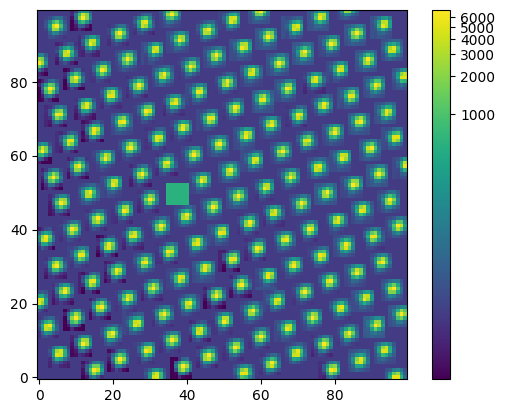

In [6]:
#Runs model_gen_sub on one subsection and plots results
artificial_extracted_image = np.zeros((len(flat),len(flat)))+47
#nddata=NDData(data=flat)
same_model_bounds = [1400,1500,1400,1500]; model_input_bounds = [1400,1500,1400,1500]
artificial_extracted_image, epsf = model_gen_sub([same_model_bounds, model_input_bounds, 3])

im = plt.imshow(artificial_extracted_image[1400:1500,1400:1500],
                 norm=simple_norm(artificial_extracted_image[1400:1500,1400:1500], 'log', percent=99.), origin='lower')
plt.colorbar()

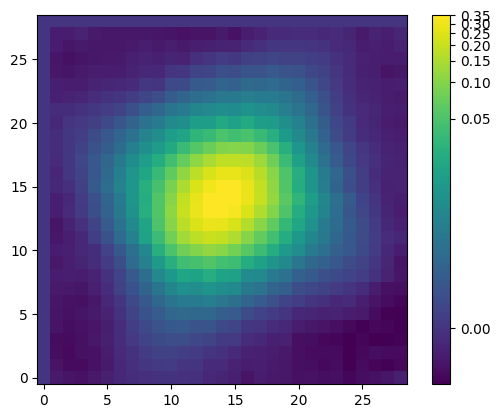

In [7]:
plt.imshow(epsf.data, norm=simple_norm(epsf.data, 'log', percent=99.), origin='lower'); plt.colorbar(); plt.show()


# spots: 172; extracted: 152


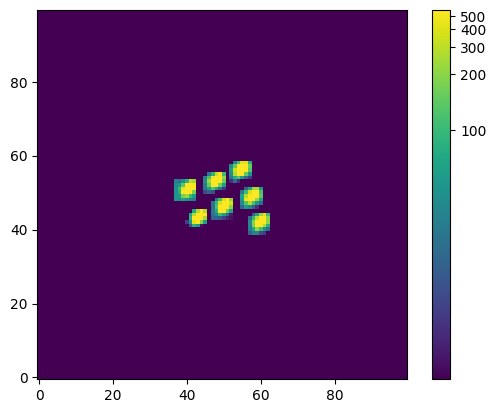

In [15]:
#nddata=NDData(data=flat)
same_model_bounds = [340,360,340,360]; model_input_bounds = [300,400,300,400]
artificial_extracted_image, epsf = model_gen_sub([same_model_bounds, model_input_bounds, 3])

im = plt.imshow(artificial_extracted_image[300:400,300:400],
                 norm=simple_norm(artificial_extracted_image[300:400,300:400], 'log', percent=99.), origin='lower')
plt.colorbar()

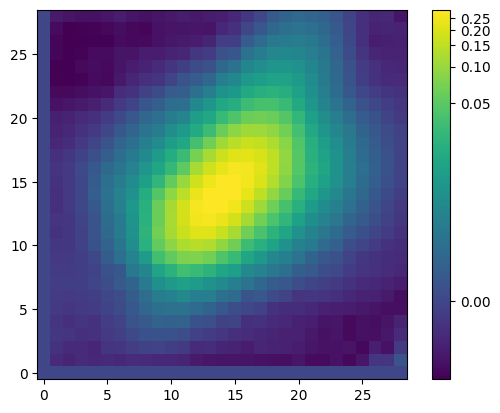

In [16]:
plt.imshow(epsf.data, norm=simple_norm(epsf.data, 'log', percent=99.), origin='lower'); plt.colorbar(); plt.show()

In [9]:
# Do timing exercise to see which lines spend the most time
from line_profiler import LineProfiler
lp = LineProfiler()
lp_wrapper = lp(model_gen_sub)
lp_wrapper([[200,300,200,300],[200,300,200,300],3])
lp.print_stats()


# spots: 171; extracted: 152
Timer unit: 1e-07 s

Total time: 11.1256 s
File: C:\Users\user\AppData\Local\Temp\ipykernel_6136\2206831602.py
Function: model_gen_sub at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def model_gen_sub(argument):
     3                                               
     4                                               #Bounds for the box in which a single model is recycled
     5         1         15.0     15.0      0.0      same_model_bounds = argument[0]
     6                                               #Bounds for the box from which the sample spots are drawn
     7         1          8.0      8.0      0.0      model_input_bounds = argument[1]
     8                                               #Half-width of the box drawn around each ePSF
     9         1          8.0      8.0      0.0      box_half_width = argument[2]
    10                                               
   